# BERT Cased with Interweaving Fine-Tuned Approach on Disability and Gender

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.3 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERT Cased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained BERT Cased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertcased model instance
    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Gender

In [6]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Gender
gender_train_df, gender_val_df, gender_test_df = load_data('gender')
X_gender_train, y_gender_train, X_gender_test, y_gender_test, X_gender_val, y_gender_val = load_data_as_arr(gender_train_df, gender_val_df, gender_test_df)

In [7]:
X_disability_train[1]

' mental disability is extremely physical'

In [8]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [9]:
len(X_disability_train)

24904

In [10]:
X_gender_train[0]

' sexual harassment in the workplace is no big deal as long as you are not fat'

In [11]:
len(X_gender_train)

14993

## Load BERT Cased Model from_pretrained()

In [12]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [14]:
# Disability
bertcased_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertcased_tokenizer)
bertcased_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertcased_tokenizer)
bertcased_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertcased_tokenizer)

# Gender
bertcased_gender_train_inputs = tokenizing_pipeline(X_gender_train, bertcased_tokenizer)
bertcased_gender_test_inputs = tokenizing_pipeline(X_gender_test, bertcased_tokenizer)
bertcased_gender_val_inputs = tokenizing_pipeline(X_gender_val, bertcased_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [15]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for religon train set:

In [16]:
neg, pos = np.bincount(y_gender_train)
total = neg + pos
print('Gender Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

gender_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Gender Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Gender Train Weight for class 1: {:.2f}'.format(weight_for_1))

Gender Train Examples:
    Total: 14993
    Positive: 7620 (50.82% of total)

Gender Train Weight for class 0: 1.02
Gender Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [17]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [18]:
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Gender Model

In [19]:
gender_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
gender_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Gender Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [20]:
disability_round1_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 96s 76ms/step - loss: 0.5962 - binary_accuracy: 0.6735 - precision: 0.6934 - recall: 0.6725 - f1_score: 0.6827 - val_loss: 0.4936 - val_binary_accuracy: 0.7657 - val_precision: 0.7870 - val_recall: 0.7515 - val_f1_score: 0.7688


## Round 2: Train Gender Model for 1 epoch

In [21]:
gender_round2_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 67s 82ms/step - loss: 0.6110 - binary_accuracy: 0.6664 - precision_1: 0.6524 - recall_1: 0.7356 - f1_score: 0.6915 - val_loss: 0.4534 - val_binary_accuracy: 0.8032 - val_precision_1: 0.8027 - val_recall_1: 0.8213 - val_f1_score: 0.8119


## Round 3: Train Disability Model for 1 epoch

In [22]:
disability_round3_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 75ms/step - loss: 0.4866 - binary_accuracy: 0.7689 - precision: 0.7863 - recall: 0.7657 - f1_score: 0.7759 - val_loss: 0.4595 - val_binary_accuracy: 0.7791 - val_precision: 0.7932 - val_recall: 0.7766 - val_f1_score: 0.7848


## Round 4: Train Gender Model on for 1 epoch

In [23]:
gender_round4_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.4475 - binary_accuracy: 0.7979 - precision_1: 0.8015 - recall_1: 0.8007 - f1_score: 0.8011 - val_loss: 0.3921 - val_binary_accuracy: 0.8212 - val_precision_1: 0.8484 - val_recall_1: 0.7966 - val_f1_score: 0.8217


## Round 5: Train Disability Model for 1 epoch

In [24]:
disability_round5_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4567 - binary_accuracy: 0.7850 - precision: 0.8040 - recall: 0.7782 - f1_score: 0.7909 - val_loss: 0.4445 - val_binary_accuracy: 0.7907 - val_precision: 0.8181 - val_recall: 0.7668 - val_f1_score: 0.7917


### Checkpoint #1: Save Model Weights for Disability

In [25]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_disability-checkpt1-round_5.hdf5')

## Round 6: Train Gender Model for 1 epoch

In [26]:
gender_round6_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.4019 - binary_accuracy: 0.8241 - precision_1: 0.8292 - recall_1: 0.8234 - f1_score: 0.8263 - val_loss: 0.3725 - val_binary_accuracy: 0.8396 - val_precision_1: 0.8674 - val_recall_1: 0.8144 - val_f1_score: 0.8400



## Round 7: Train Disability Model for 1 epoch

In [27]:
disability_round7_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4365 - binary_accuracy: 0.7974 - precision: 0.8168 - recall: 0.7891 - f1_score: 0.8028 - val_loss: 0.4315 - val_binary_accuracy: 0.7958 - val_precision: 0.8136 - val_recall: 0.7863 - val_f1_score: 0.7997


### Checkpoint #2: Save Model Weights for Disability

In [28]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_disability-checkpt2-round_7.hdf5')

## Round 8: Train Gender Model for 1 epoch

In [29]:
gender_round8_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3780 - binary_accuracy: 0.8365 - precision_1: 0.8406 - recall_1: 0.8369 - f1_score: 0.8387 - val_loss: 0.3555 - val_binary_accuracy: 0.8448 - val_precision_1: 0.8623 - val_recall_1: 0.8329 - val_f1_score: 0.8474


## Round 9: Train Disability Model for 1 epoch

In [30]:
disability_round9_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4267 - binary_accuracy: 0.8052 - precision: 0.8237 - recall: 0.7978 - f1_score: 0.8105 - val_loss: 0.4259 - val_binary_accuracy: 0.8023 - val_precision: 0.8147 - val_recall: 0.8007 - val_f1_score: 0.8077


### Checkpoint #3: Save Model Weights for Disability

In [31]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_disability-checkpt3-round_9.hdf5')

## Round 10: Train Gender Model for 1 epoch

In [32]:
gender_round10_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3599 - binary_accuracy: 0.8466 - precision_1: 0.8506 - recall_1: 0.8470 - f1_score: 0.8488 - val_loss: 0.3444 - val_binary_accuracy: 0.8544 - val_precision_1: 0.8731 - val_recall_1: 0.8407 - val_f1_score: 0.8566


### Checkpoint #4: Save Model Weights for Gender Round 10

In [33]:
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_gender-checkpt4-round_10.hdf5')

## Round 11: Train Disability Model for 1 epoch

In [34]:
disability_round11_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4136 - binary_accuracy: 0.8107 - precision: 0.8313 - recall: 0.7998 - f1_score: 0.8153 - val_loss: 0.4203 - val_binary_accuracy: 0.8085 - val_precision: 0.8338 - val_recall: 0.7877 - val_f1_score: 0.8101


## Round 12: Train Gender for 1 epoch

In [35]:
gender_round12_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3475 - binary_accuracy: 0.8529 - precision_1: 0.8552 - recall_1: 0.8552 - f1_score: 0.8552 - val_loss: 0.3353 - val_binary_accuracy: 0.8576 - val_precision_1: 0.8739 - val_recall_1: 0.8469 - val_f1_score: 0.8602


### Checkpoint #5: Save Model Weights for Gender Round 12

In [36]:
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_gender-checkpt5-round_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [37]:
disability_round13_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4041 - binary_accuracy: 0.8158 - precision: 0.8348 - recall: 0.8071 - f1_score: 0.8207 - val_loss: 0.4158 - val_binary_accuracy: 0.8138 - val_precision: 0.8443 - val_recall: 0.7859 - val_f1_score: 0.8140


## Round 14: Train Gender Model on for 1 epoch

In [38]:
gender_round14_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3354 - binary_accuracy: 0.8591 - precision_1: 0.8627 - recall_1: 0.8594 - f1_score: 0.8611 - val_loss: 0.3315 - val_binary_accuracy: 0.8604 - val_precision_1: 0.8825 - val_recall_1: 0.8422 - val_f1_score: 0.8619


### Checkpoint #6: Save Model Weights for Gender Round 14

In [39]:
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_gender-checkpt6-round_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [40]:
disability_round15_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.3981 - binary_accuracy: 0.8185 - precision: 0.8388 - recall: 0.8077 - f1_score: 0.8230 - val_loss: 0.4112 - val_binary_accuracy: 0.8167 - val_precision: 0.8425 - val_recall: 0.7952 - val_f1_score: 0.8182


## Round 16: Train Gender Model on for 1 epoch

In [41]:
gender_round16_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3268 - binary_accuracy: 0.8657 - precision_1: 0.8675 - recall_1: 0.8684 - f1_score: 0.8679 - val_loss: 0.3256 - val_binary_accuracy: 0.8648 - val_precision_1: 0.8793 - val_recall_1: 0.8561 - val_f1_score: 0.8676


### Checkpoint #7: Save Model Weights for Rounds 15 and 16

In [42]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_disability-checkpt7-rounds_15_16.hdf5')
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_gender-checkpt7-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [43]:
disability_round17_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.3890 - binary_accuracy: 0.8241 - precision: 0.8440 - recall: 0.8137 - f1_score: 0.8285 - val_loss: 0.4094 - val_binary_accuracy: 0.8206 - val_precision: 0.8563 - val_recall: 0.7859 - val_f1_score: 0.8196


## Round 18: Train Gender Model for 1 epoch

In [44]:
gender_round18_history = gender_model.fit(bertcased_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertcased_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 48s 77ms/step - loss: 0.3204 - binary_accuracy: 0.8673 - precision_1: 0.8698 - recall_1: 0.8689 - f1_score: 0.8694 - val_loss: 0.3243 - val_binary_accuracy: 0.8692 - val_precision_1: 0.8933 - val_recall_1: 0.8484 - val_f1_score: 0.8703


# Plots for Disability Model

In [45]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

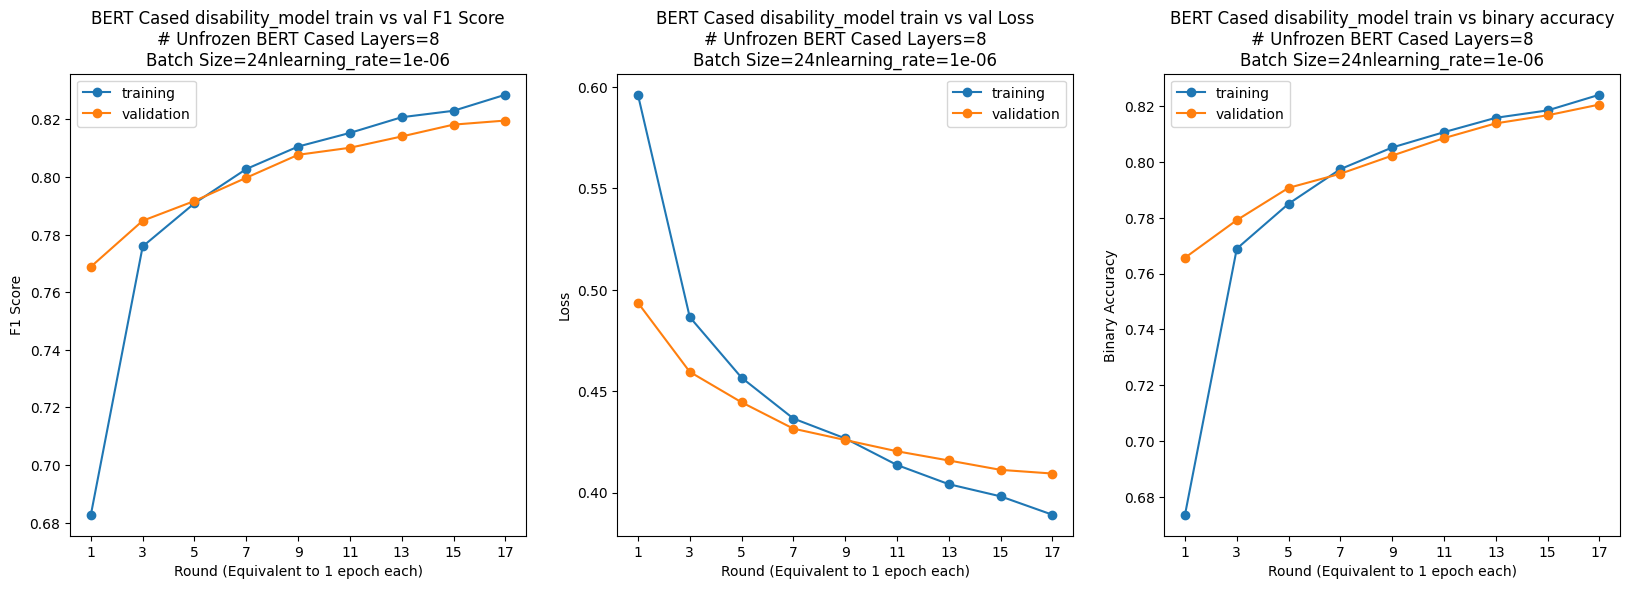

In [46]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERT Cased disability_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERT Cased disability_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERT Cased disability_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Gender Model

In [47]:
gender_train_f1_scores = [gender_round2_history.history['f1_score'][0][0],
                     gender_round4_history.history['f1_score'][0][0],
                     gender_round6_history.history['f1_score'][0][0],
                     gender_round8_history.history['f1_score'][0][0],
                     gender_round10_history.history['f1_score'][0][0],
                     gender_round12_history.history['f1_score'][0][0],
                     gender_round14_history.history['f1_score'][0][0],
                     gender_round16_history.history['f1_score'][0][0],
                     gender_round18_history.history['f1_score'][0][0]]
gender_val_f1_scores = [gender_round2_history.history['val_f1_score'][0][0],
                     gender_round4_history.history['val_f1_score'][0][0],
                     gender_round6_history.history['val_f1_score'][0][0],
                     gender_round8_history.history['val_f1_score'][0][0],
                     gender_round10_history.history['val_f1_score'][0][0],
                     gender_round12_history.history['val_f1_score'][0][0],
                     gender_round14_history.history['val_f1_score'][0][0],
                     gender_round16_history.history['val_f1_score'][0][0],
                     gender_round18_history.history['val_f1_score'][0][0]]
gender_train_loss = [gender_round2_history.history['loss'][0],
                     gender_round4_history.history['loss'][0],
                     gender_round6_history.history['loss'][0],
                     gender_round8_history.history['loss'][0],
                     gender_round10_history.history['loss'][0],
                     gender_round12_history.history['loss'][0],
                     gender_round14_history.history['loss'][0],
                     gender_round16_history.history['loss'][0],
                     gender_round18_history.history['loss'][0]]
gender_val_loss = [gender_round2_history.history['val_loss'][0],
                     gender_round4_history.history['val_loss'][0],
                     gender_round6_history.history['val_loss'][0],
                     gender_round8_history.history['val_loss'][0],
                     gender_round10_history.history['val_loss'][0],
                     gender_round12_history.history['val_loss'][0],
                     gender_round14_history.history['val_loss'][0],
                     gender_round16_history.history['val_loss'][0],
                     gender_round18_history.history['val_loss'][0]]
gender_train_binary_accuracy = [gender_round2_history.history['binary_accuracy'][0],
                     gender_round4_history.history['binary_accuracy'][0],
                     gender_round6_history.history['binary_accuracy'][0],
                     gender_round8_history.history['binary_accuracy'][0],
                     gender_round10_history.history['binary_accuracy'][0],
                     gender_round12_history.history['binary_accuracy'][0],
                     gender_round14_history.history['binary_accuracy'][0],
                     gender_round16_history.history['binary_accuracy'][0],
                     gender_round18_history.history['binary_accuracy'][0]]
gender_val_binary_accuracy = [gender_round2_history.history['val_binary_accuracy'][0],
                     gender_round4_history.history['val_binary_accuracy'][0],
                     gender_round6_history.history['val_binary_accuracy'][0],
                     gender_round8_history.history['val_binary_accuracy'][0],
                     gender_round10_history.history['val_binary_accuracy'][0],
                     gender_round12_history.history['val_binary_accuracy'][0],
                     gender_round14_history.history['val_binary_accuracy'][0],
                     gender_round16_history.history['val_binary_accuracy'][0],
                     gender_round18_history.history['val_binary_accuracy'][0]]


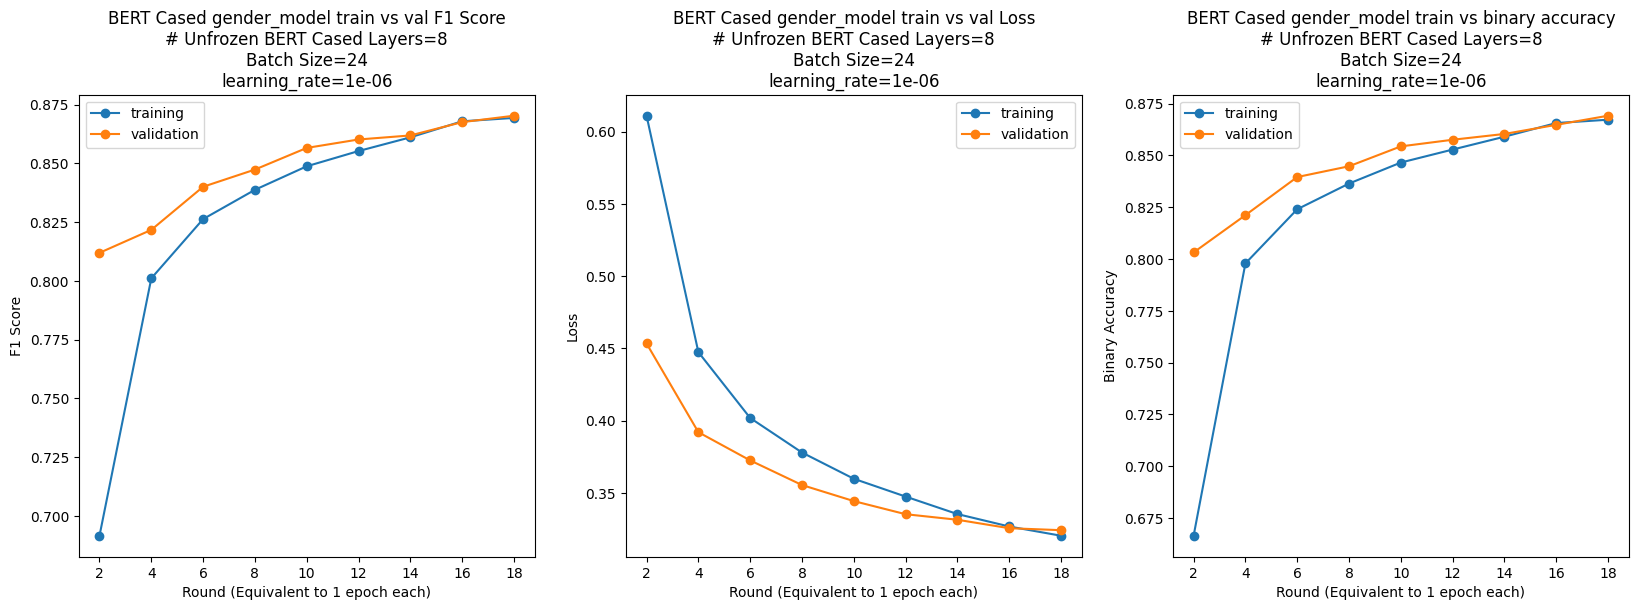

In [48]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(gender_train_f1_scores, label="training", marker='o')
axis[0].plot(gender_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERT Cased gender_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'\nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(gender_train_loss, label="training", marker='o')
axis[1].plot(gender_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERT Cased gender_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'\nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(gender_train_binary_accuracy, label="training", marker='o')
axis[2].plot(gender_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERT Cased gender_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'\nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_disability.hdf5')
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Gender_Interwoven_gender.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training
Looking at the train/val curves below, we'll keep the weights from checkpoint #2 at rounds 13 and 14.

DISABILITY MODEL RESULTS

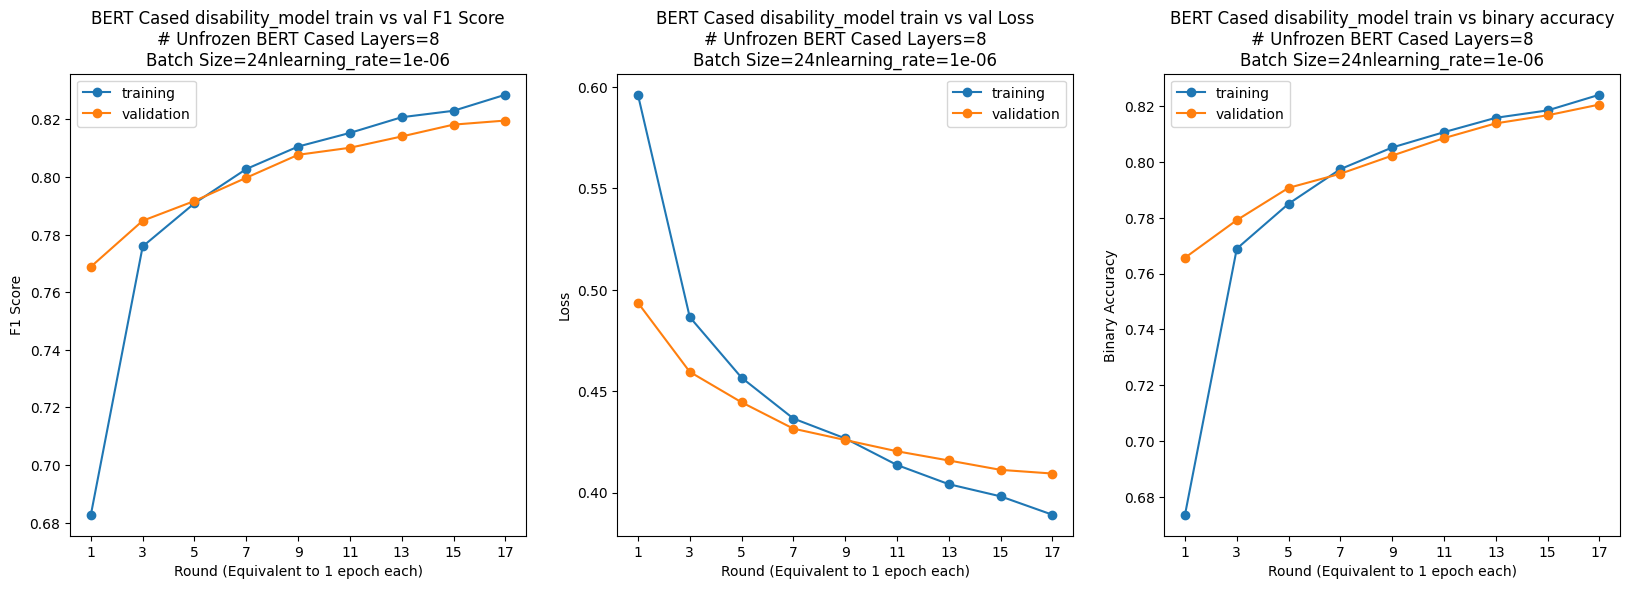

In [ ]:
# 3:30pm
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at checkpoint # at round ___

In [51]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

disability_train_f1_scores: [0.6752014, 0.77842134, 0.78958446, 0.7987814, 0.80822074, 0.8136417, 0.8190208, 0.8248004, 0.8280889]
disability_val_f1_scores: [0.7674922, 0.7872941, 0.78751206, 0.795422, 0.797862, 0.80652016, 0.80743563, 0.8103657, 0.81595826]

disability_train_loss: [0.5940549969673157, 0.48834019899368286, 0.4607892632484436, 0.44220098853111267, 0.42835813760757446, 0.4152229428291321, 0.40658777952194214, 0.39681971073150635, 0.39024272561073303]
disability_val_loss: [0.4921875596046448, 0.4600716531276703, 0.44941821694374084, 0.436095654964447, 0.4303969740867615, 0.42038825154304504, 0.41718217730522156, 0.41515877842903137, 0.4118255078792572]

disability_train_binary_accuracy: [0.67298424243927, 0.7695952653884888, 0.7832476496696472, 0.7931256294250488, 0.8032845854759216, 0.8091069459915161, 0.8141664266586304, 0.8202698230743408, 0.8238435387611389]
disability_val_binary_accuracy: [0.7671002149581909, 0.7822735905647278, 0.7885356545448303, 0.7933526039123535

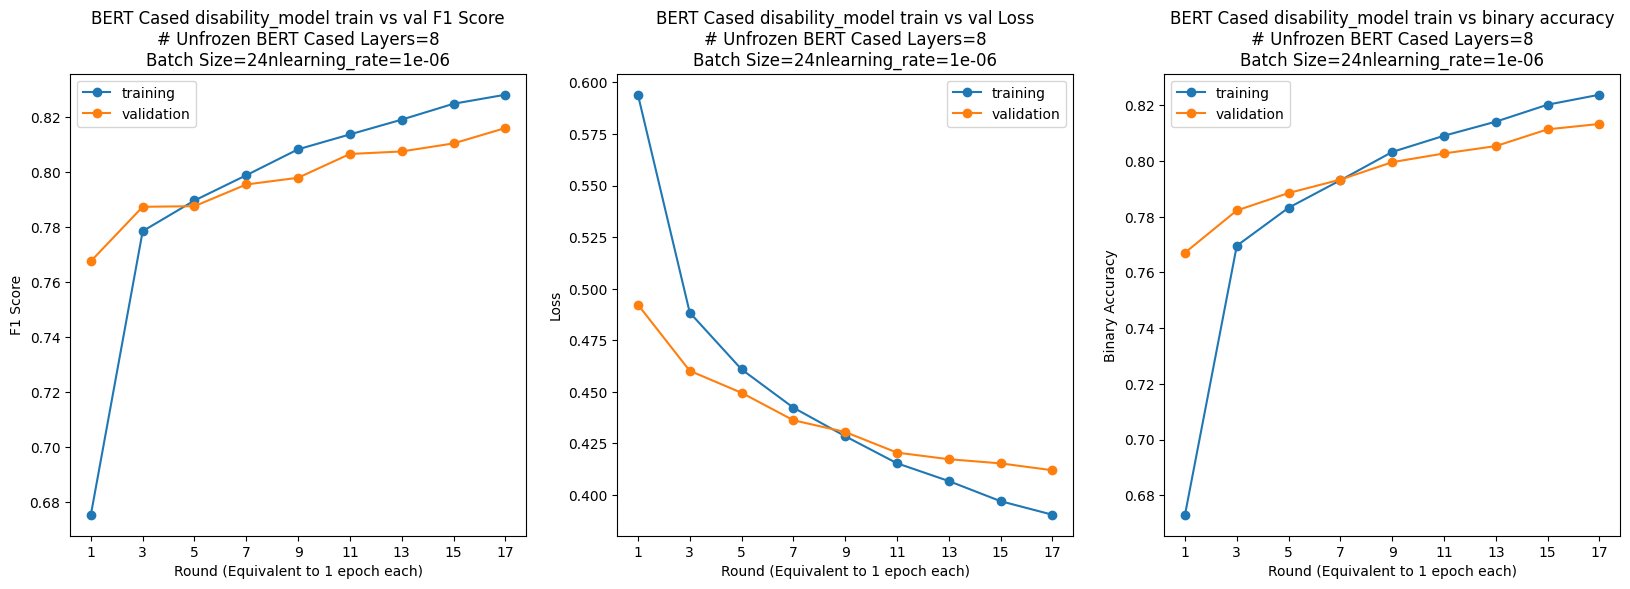

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at checkpoint # at round ___

GENDER MODEL RESULTS

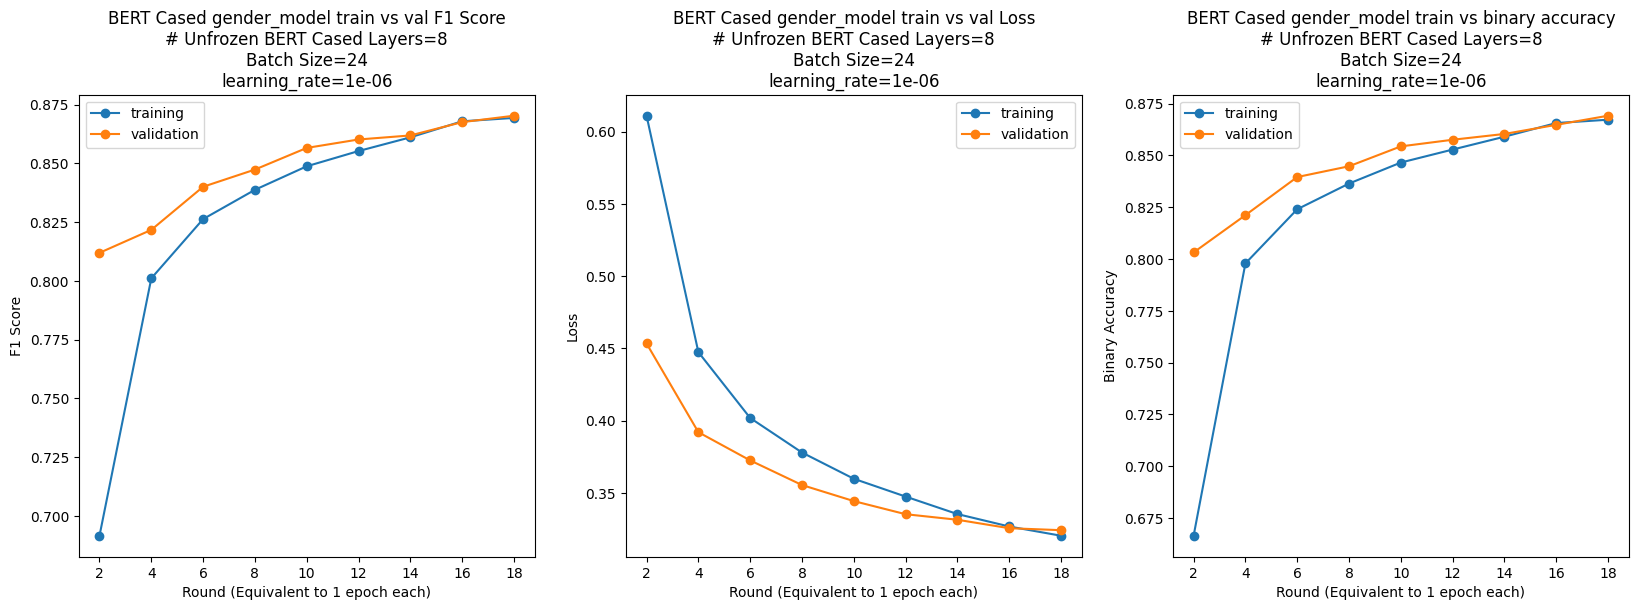

In [ ]:
# 3:30pm
# GENDER MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the gender_model weights at checkpoint # at round ___

In [52]:
print('gender_train_f1_scores:', gender_train_f1_scores)
print('gender_val_f1_scores:', gender_val_f1_scores)
print('\ngender_train_loss:', gender_train_loss)
print('gender_val_loss:', gender_val_loss)
print('\ngender_train_binary_accuracy:', gender_train_binary_accuracy)
print('gender_val_binary_accuracy:', gender_val_binary_accuracy)

gender_train_f1_scores: [0.69097847, 0.7971889, 0.8258184, 0.8336535, 0.8478348, 0.8530825, 0.8574814, 0.869977, 0.8701085]
gender_val_f1_scores: [0.8017343, 0.8121162, 0.8319936, 0.8469184, 0.8521323, 0.86505467, 0.86293197, 0.8626198, 0.8714117]

gender_train_loss: [0.6021115779876709, 0.4450465738773346, 0.40252313017845154, 0.38269591331481934, 0.359504759311676, 0.35188865661621094, 0.3410561680793762, 0.3279573321342468, 0.31695660948753357]
gender_val_loss: [0.4484781324863434, 0.39790207147598267, 0.37208306789398193, 0.3556051552295685, 0.3478626608848572, 0.335496187210083, 0.3347734808921814, 0.3323381841182709, 0.3217661678791046]

gender_train_binary_accuracy: [0.6648436188697815, 0.7959714531898499, 0.8250516653060913, 0.8325218558311462, 0.8467284440994263, 0.8510638475418091, 0.8555992841720581, 0.8681384921073914, 0.8682718873023987]
gender_val_binary_accuracy: [0.798799991607666, 0.8163999915122986, 0.8327999711036682, 0.8460000157356262, 0.8515999913215637, 0.8615999

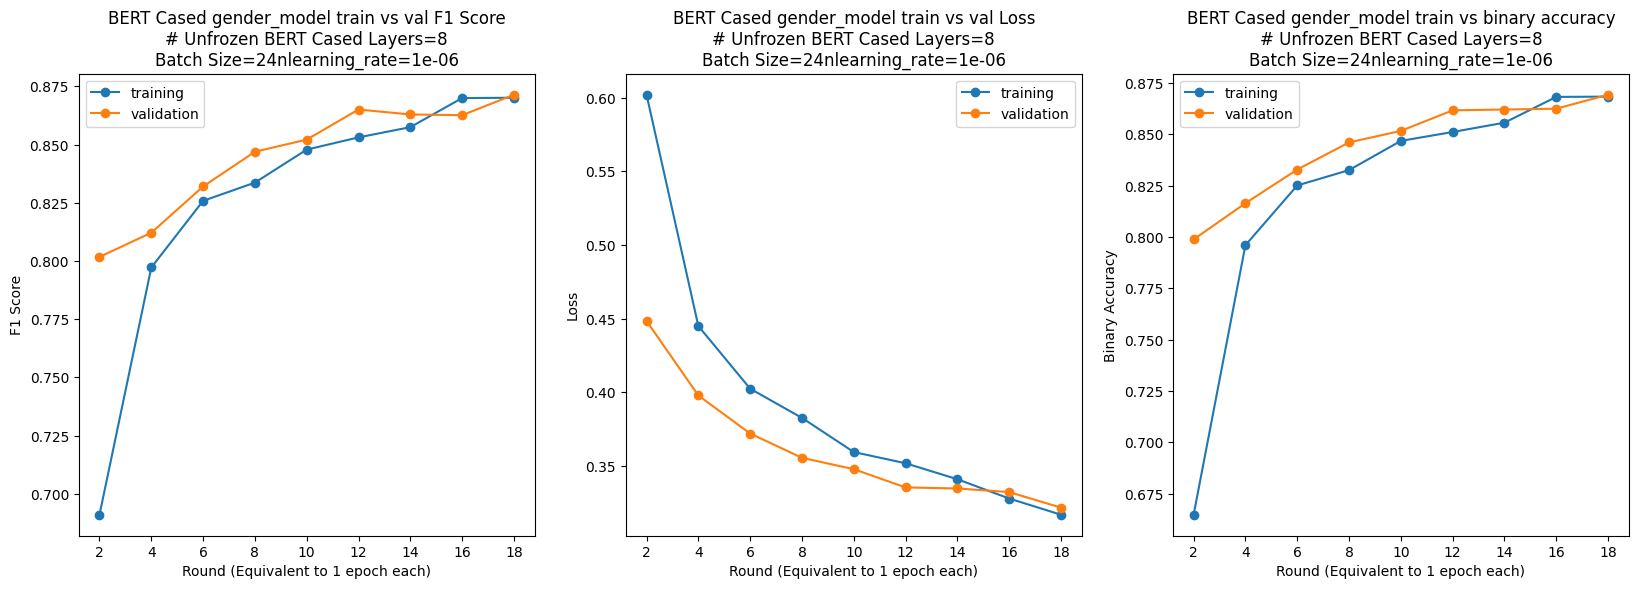

In [ ]:
# GENDER MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the gender_model weights at checkpoint # at round ___